In [1]:
from qiskit import QuantumCircuit, QuantumRegister, transpile, ClassicalRegister, result
from qiskit_aer import QasmSimulator
import qiskit_aer
import qiskit_aer.primitives
from qiskit_aer import Aer
from qiskit_aer.primitives import SamplerV2
from qiskit_aer.primitives import EstimatorV2
from qiskit.quantum_info import Statevector
import numpy as np
from qiskit_ibm_runtime.fake_provider import FakeValenciaV2
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_state_qsphere, plot_bloch_multivector
from qiskit.visualization import plot_bloch_vector
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
from qiskit_algorithms.optimizers import ADAM, SPSA
import random

des_theta = [random.uniform(0, 2 * np.pi),random.uniform(0, 2 * np.pi),random.uniform(0, 2 * np.pi)]
print(des_theta)

sim = AerSimulator()
sim_statevector = AerSimulator(method='statevector')

[1.941490021613417, 5.118130836594284, 4.002024542724455]


In [2]:
def create_circuit(theta1,theta2,theta3):
    #theta_init=des_theta
    circuit = QuantumCircuit(4)
    circuit.h(0)
    circuit.cx(0,1)
    circuit.rx(theta1,0)
    circuit.cy(1,0)
    circuit.cy(2,0)
    circuit.rx(theta2,2)
    circuit.cy(3,0)
    circuit.ry(theta3,0)
    circuit.cy(3,1)
    circuit.cx(1,2)
    circuit.ry(theta2,1)
    circuit.rz(theta1,3)
    circuit.rz(theta3,1)
    return circuit
qc=create_circuit(des_theta[0],des_theta[1],des_theta[2])
qc.draw()

┌───┐     ┌────────────┐┌───┐┌───┐              ┌───┐┌───────────┐»
q_0: ┤ H ├──■──┤ Rx(1.9415) ├┤ Y ├┤ Y ├──────────────┤ Y ├┤ Ry(4.002) ├»
     └───┘┌─┴─┐└────────────┘└─┬─┘└─┬─┘              └─┬─┘└───┬───┬───┘»
q_1: ─────┤ X ├────────────────■────┼──────────────────┼──────┤ Y ├────»
          └───┘                     │  ┌────────────┐  │      └─┬─┘    »
q_2: ───────────────────────────────■──┤ Rx(5.1181) ├──┼────────┼──────»
                                       └────────────┘  │        │      »
q_3: ──────────────────────────────────────────────────■────────■──────»
                                                                       »
«                                              
«q_0: ─────────────────────────────────────────
«                   ┌────────────┐┌───────────┐
«q_1: ──────■───────┤ Ry(5.1181) ├┤ Rz(4.002) ├
«         ┌─┴─┐     └────────────┘└───────────┘
«q_2: ────┤ X ├────────────────────────────────
«     ┌───┴───┴────┐                           
«q_3: ┤ Rz(1.9415) ├───────────────────────────
«     └────────────┘

In [3]:
def target_state(theta1,theta2,theta3):
    #des_theta2=theta1,theta2,theta3
    circuit = create_circuit(theta1,theta2,theta3)
    #print(circuit)
    backend = Aer.get_backend('aer_simulator')
    circuit.save_statevector()
    circuit.measure_all()
    job = transpile(circuit, backend)
    #print(job)
    result = backend.run(job).result()
    state=result.get_statevector()
    
    output_state = result.get_statevector(job)
    return output_state
    
des_state=target_state(des_theta[0],des_theta[1],des_theta[2])
print(des_state)

Statevector([ 0.1995201 -0.17819057j, -0.34144869-0.15602339j,
              0.4178616 -0.25077923j,  0.19174934-0.11507818j,
              0.48032669+0.08236995j,  0.22041347+0.03779812j,
             -0.25051964-0.09380863j,  0.26173487-0.26911962j,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ],
            dims=(2, 2, 2, 2))


In [4]:
def fidelity(theta1,theta2,theta3):
    output_state = target_state(theta1,theta2,theta3)
    #print(output_state)
    return state_fidelity(output_state,des_state)

In [5]:
class AdamOptimizer:
    def __init__(self, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-5):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = 0
        self.v = 0
        self.t = 0

    def update(self, theta, grad):
        self.t += 1
        self.m = self.beta1 * self.m + (1 - self.beta1) * grad
        self.v = self.beta2 * self.v + (1 - self.beta2) * (grad ** 2)

        m_hat = self.m / (1 - self.beta1 ** self.t)
        v_hat = self.v / (1 - self.beta2 ** self.t)

        theta -= self.lr * m_hat / (np.sqrt(v_hat) + self.epsilon)
        return theta

In [6]:
tolerance = 1e-4  # Define tolerance
optimizer = AdamOptimizer(lr=0.01)

In [8]:
temp_m1=1.1
dat=[]
#theta = [random.uniform(0, 2 * np.pi),random.uniform(0, 2 * np.pi),random.uniform(0, 2 * np.pi)]
theta=[0,0,0]
print(theta)
init_fid=fidelity(theta[0],theta[1],theta[2])
target=des_state
print(init_fid)
for epoch in range(300):
    grad = (-fidelity(theta[0] + 1e-5,theta[1] + 1e-5,theta[2] + 1e-5) + fidelity(theta[0] - 1e-5,theta[1] - 1e-5,theta[2] - 1e-5)) / (2 * 1e-5)
    #print(optimizer.update(thet, grad))
    temp=fidelity(theta[0],theta[1],theta[2])
    new_theta = optimizer.update(theta, grad)
    if abs(new_theta[0] - theta[0]) < tolerance and abs(new_theta[1] - theta[1]) < tolerance and abs(new_theta[2] - theta[2]) < tolerance:
        if abs(temp_m1 - temp) < tolerance: #and abs(new_theta[1] - theta[1]) < tolerance and abs(new_theta[2] - theta[2]) < tolerance:
            print("Optimal theta found: ", new_theta, "Fidelity: ", temp)
            break #### PROB SHOULD BREAK FOR FID MAX @1
    #print(temp)
    dat.append((epoch,theta[0], theta[1], theta[2], temp,grad))
    theta=new_theta
    temp_m1=grad

[0, 0, 0]
0.13491709772787275


In [9]:
epochs=[]
thetas0=[]
thetas1=[]
thetas2=[]
newthetas=[]
fid=[]
gradients=[]
for i in range(len(dat)):
    #print(dat[i][0],dat[i][1],dat[i][3],dat[i][4])
    epochs.append(dat[i][0])
    thetas0.append(dat[i][1])
    thetas1.append(dat[i][2])
    thetas2.append(dat[i][3])
   # newthetas.append(dat[i][2])
    fid.append(dat[i][4])
    gradients.append(dat[i][5])
finalthet=thetas0[len(dat)-1],thetas1[len(dat)-1],thetas2[len(dat)-1]
print(finalthet)

(np.float64(0.7356478742319028), np.float64(0.7356478742319028), np.float64(0.7356478742319028))


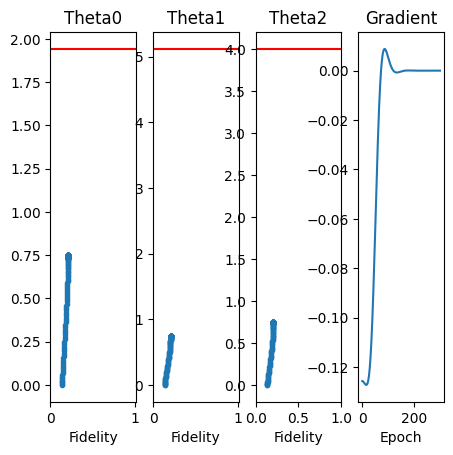

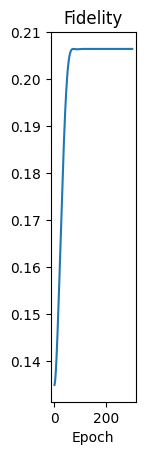

desired state: Statevector([ 0.1995201 -0.17819057j, -0.34144869-0.15602339j,
              0.4178616 -0.25077923j,  0.19174934-0.11507818j,
              0.48032669+0.08236995j,  0.22041347+0.03779812j,
             -0.25051964-0.09380863j,  0.26173487-0.26911962j,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ,
              0.        +0.j        ,  0.        +0.j        ],
            dims=(2, 2, 2, 2)) desired theta:  [1.941490021613417, 5.118130836594284, 4.002024542724455]
converged state: Statevector([ 5.01949213e-01-0.36290426j,  5.78599740e-02-0.28962964j,
             -5.20417043e-17+0.0613559j ,  0.00000000e+00-0.15921632j,
              4.54890239e-02-0.04117395j, -1.18042366e-01+0.10684492j,
             -6.77860501e-02-0.61567651j,  1.75902340e-01-0.23725824j,
              0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
   

In [10]:
plt.subplot(1, 5, 1)
plt.plot(fid,thetas0, '.-')
plt.title('Theta0')
#plt.ylabel('Theta')
plt.xlabel('Fidelity')
plt.axhline(y=des_theta[0], color='r', linestyle='-')
ax = plt.gca()
ax.set_xlim([0, 1.01])

plt.subplot(1, 5, 2)
plt.plot(fid,thetas1, '.-')
plt.title('Theta1')
plt.xlabel('Fidelity')
plt.axhline(y=des_theta[1], color='r', linestyle='-')
ax = plt.gca()
ax.set_xlim([0, 1.01])

plt.subplot(1, 5, 3)
plt.plot(fid,thetas2, '.-')
plt.title('Theta2')
plt.xlabel('Fidelity')
plt.axhline(y=des_theta[2], color='r', linestyle='-')
ax = plt.gca()
ax.set_xlim([0, 1.])

plt.subplot(1, 5, 4)
plt.plot(epochs,gradients, '-')
plt.title('Gradient')
plt.xlabel('Epoch')
#plt.ylabel('Epoch')
#ax = plt.gca()
#ax.set_ylim([-1e-10, 1e-10])
plt.show()

plt.subplot(1, 5, 5)
plt.plot(epochs,fid, '-')
plt.title('Fidelity')
plt.xlabel('Epoch')
#plt.ylabel('Epoch')
#ax = plt.gca()
#ax.set_ylim([-1e-10, 1e-10])
plt.show()

print('desired state:', des_state, 'desired theta: ',des_theta)
print('converged state:', target_state(finalthet[0],finalthet[1],finalthet[2]), 'converged theta: ',finalthet[0],finalthet[1],finalthet[2])